In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import matthews_corrcoef
from sklearn.feature_selection import chi2
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from nltk.tokenize import word_tokenize
import numpy as np
!pip install gensim
from gensim.models import Word2Vec

## Load Dataset

In [ ]:
df = pd.read_csv("lemmatized_original_train.csv")
df_test = pd.read_csv("lemmatized_original_test.csv")
print(len(df))
print(len(df_test))

5360
1341


In [ ]:
df.drop(columns=['Unnamed: 0'], inplace=True)
df_test.drop(columns=['Unnamed: 0'], inplace=True)

In [ ]:
X_train = df['lemmatized and stopwords_removed']
y_train = df['sentiment']
X_test = df_test['lemmatized and stopwords_removed']
y_test = df_test['sentiment']

## Generating n-grams

In [ ]:
# TfidfVectorizer (Unigram)  
corpus = X_train

vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1, 1), token_pattern=u"(?u)\\b\\w+\\b", min_df=10)

train_counts_unigram = vectorizer.fit_transform(corpus)
test_counts_unigram = vectorizer.transform(X_test)

# initialize vectorized text dataframe
df_vectorized_text_unigrams_train = pd.DataFrame(data=train_counts_unigram.toarray(), columns=vectorizer.get_feature_names())
df_vectorized_text_unigrams_test = pd.DataFrame(data=test_counts_unigram.toarray(), columns=vectorizer.get_feature_names())

################################################################

# TfidfVectorizer (Unigram & Bigram)  
corpus = X_train

vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), token_pattern=u"(?u)\\b\\w+\\b", min_df=10)

train_counts_unigram_and_bigram = vectorizer.fit_transform(corpus)
test_counts_unigram_and_bigram = vectorizer.transform(X_test)

# initialize vectorized text dataframe
df_vectorized_text_unigrams_and_bigrams_train = pd.DataFrame(data=train_counts_unigram_and_bigram.toarray(), columns=vectorizer.get_feature_names())
df_vectorized_text_unigrams_and_bigrams_test = pd.DataFrame(data=test_counts_unigram_and_bigram.toarray(), columns=vectorizer.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Baseline (Unigrams) Results

## Training without Chi Square Feature Selection

In [ ]:
X_train = df_vectorized_text_unigrams_train
X_test = df_vectorized_text_unigrams_test

clf = LinearSVC(random_state=0).fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
print('Train Accuracy: ' + '{:.2%}'.format(accuracy_score(y_train, y_train_pred)))

y_test_pred = clf.predict(X_test)
print('Test Accuracy: ' + '{:.2%}'.format(accuracy_score(y_test, y_test_pred)))
print('Test F1 Score: ' + '{:.2%}'.format(f1_score(y_test, y_test_pred, average='weighted')))

## Cross Validation
cross_val_accuracy_scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=10, n_jobs=-1)   
print("Mean Cross Val Accuracy: " + '{:.2%}'.format(cross_val_accuracy_scores.mean()))
    
cross_val_f1_scores = cross_val_score(clf, X_train, y_train, scoring='f1_weighted', cv=10, n_jobs=-1)
print("Mean Cross Val F1 Score: " + '{:.2%}'.format(cross_val_f1_scores.mean()))

testing_matthew_coeff = matthews_corrcoef(y_test, y_test_pred)
print("Testing Matthew's coefficient:", round(testing_matthew_coeff,3))

Train Accuracy: 73.69%
Test Accuracy: 70.99%
Test F1 Score: 68.49%
Mean Cross Val Accuracy: 67.39%
Mean Cross Val F1 Score: 64.46%
Testing Matthew's coefficient: 0.403


## Training with Chi Square Feature Selection

In [ ]:
# 0 is chi2 score, 1 is p-value
X_train = df_vectorized_text_unigrams_train
X_test = df_vectorized_text_unigrams_test

chi2_values = chi2(X_train.values, y_train)
chi2_df = pd.DataFrame(data=chi2_values, columns=X_train.columns)
chi2_df_sorted = chi2_df.sort_values(by=0, axis = 1, ascending = False)
chi2_df_sorted

,cool,wait,want,awesome,amazing,love,concern,fbi,wow,trust,worry,problem,weapon,excited,major,pretty,need,point,forward,safe,idea,hurry,wish,job,shit,omg,warn,exciting,commute,cute,people,way,nt,eliminate,fun,good,accident,crash,dangerous,fucking,...,amazon,house,transport,bridge,hey,tonight,sf,air,little,parking,movie,piece,billion,article,interesting,focus,free,social,true,ground,track,promise,hear,got,sxsw,news,cyclist,work,game,term,yr,seat,location,ok,push,add,taxi,likely,miss,possible
0,9.141837e+01,5.083446e+01,4.953162e+01,4.171775e+01,3.018552e+01,2.985713e+01,2.843903e+01,2.786273e+01,26.988647,26.851758,24.779367,23.547821,23.503280,23.229202,22.155562,20.112710,19.959232,17.512918,17.349282,16.288256,15.729438,15.502532,14.811318,14.638027,14.509565,14.303223,13.653632,13.466667,13.456770,12.985911,12.568740,12.530331,12.429572,12.175141,11.734363,11.412580,11.009748,10.911745,10.756977,10.693553,...,0.195880,0.194911,0.189739,0.187525,0.181739,0.178720,0.178608,0.176545,0.171151,0.163048,0.157547,0.145477,0.145093,0.144405,0.141996,0.141407,0.135084,0.133057,0.132891,0.122800,0.104396,0.100640,0.095037,0.08079,0.075872,0.073082,0.072669,0.068560,0.062536,0.039366,0.034357,0.031784,0.031633,0.029785,0.023950,0.022837,0.020882,0.018281,0.005155,0.003969
1,1.408491e-20,9.150328e-12,1.755277e-11,8.731822e-10,2.788037e-07,3.285543e-07,6.676397e-07,8.906028e-07,0.000001,0.000001,0.000004,0.000008,0.000008,0.000009,0.000015,0.000043,0.000046,0.000157,0.000171,0.000290,0.000384,0.000430,0.000608,0.000663,0.000707,0.000784,0.001084,0.001191,0.001196,0.001514,0.001865,0.001901,0.002000,0.002271,0.002831,0.003325,0.004067,0.004271,0.004615,0.004763,...,0.906703,0.907143,0.909492,0.910499,0.913137,0.914517,0.914567,0.915511,0.917984,0.921710,0.924249,0.929844,0.930023,0.930343,0.931464,0.931738,0.934688,0.935636,0.935714,0.940447,0.949141,0.950925,0.953593,0.96041,0.962775,0.964118,0.964318,0.966301,0.969216,0.980510,0.982968,0.984234,0.984308,0.985218,0.988097,0.988646,0.989613,0.990901,0.997426,0.998018


## Finding the optimal number of features to use based on cross validation F1-score

In [ ]:
f1_results_unigram_chi_square = {}
for n in range(1, 585, 5):
    chi2_columns_unigrams = chi2_df_sorted.columns[:n]
    X_train_df = df_vectorized_text_unigrams_train[chi2_columns_unigrams]

    #train MLR
    clf = LinearSVC(random_state=0)

    #Cross validation, cv=5
    f1 = cross_val_score(clf, X_train_df, y_train, scoring='f1_weighted', cv=5)
    
    #Storing mean cross validation F1-scores in a dictionary
    f1_results_unigram_chi_square[n] = f1.mean() 

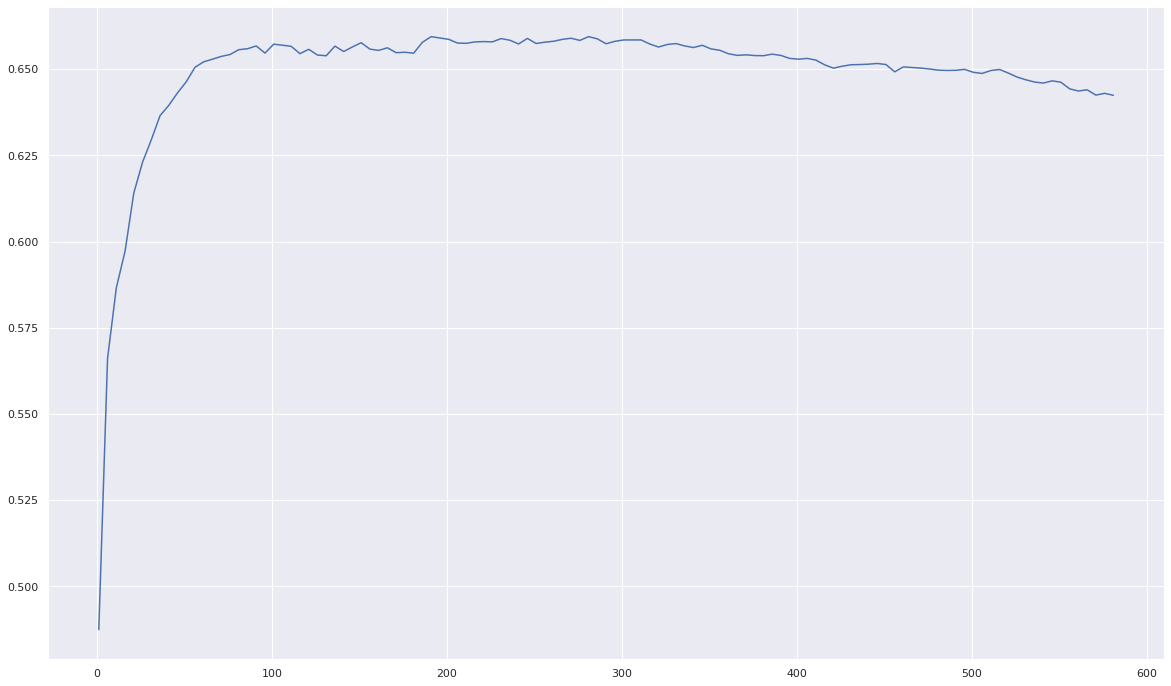

In [ ]:
sns.set(rc={'figure.figsize':(20,12)})
sns.lineplot(data=f1_results_unigram_chi_square)

In [ ]:
# Getting the optimal number of features which will result in best mean cross validation F1-score from the dictionary

best_no_of_features= max(f1_results_unigram_chi_square, key=f1_results_unigram_chi_square.get)
best_no_of_features

191

In [ ]:
# Extracting the optimal number of features into a dataframe for training

chi2_columns = chi2_df_sorted.columns[:best_no_of_features]
X_train_vectorized_unigrams_chi_square = df_vectorized_text_unigrams_train[chi2_columns]
X_test_vectorized_unigrams_chi_square = df_vectorized_text_unigrams_test[chi2_columns]

In [ ]:
X_train = X_train_vectorized_unigrams_chi_square
X_test = X_test_vectorized_unigrams_chi_square

clf = LinearSVC(random_state=0).fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
print('Train Accuracy: ' + '{:.2%}'.format(accuracy_score(y_train, y_train_pred)))

y_test_pred = clf.predict(X_test)
print('Test Accuracy: ' + '{:.2%}'.format(accuracy_score(y_test, y_test_pred)))
print('Test F1 Score: ' + '{:.2%}'.format(f1_score(y_test, y_test_pred, average='weighted')))

## Cross Validation
cross_val_accuracy_scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=10, n_jobs=-1)   
print("Mean Cross Val Accuracy: " + '{:.2%}'.format(cross_val_accuracy_scores.mean()))
    
cross_val_f1_scores = cross_val_score(clf, X_train, y_train, scoring='f1_weighted', cv=10, n_jobs=-1)
print("Mean Cross Val F1 Score: " + '{:.2%}'.format(cross_val_f1_scores.mean()))

testing_matthew_coeff = matthews_corrcoef(y_test, y_test_pred)
print("Testing Matthew's coefficient:", round(testing_matthew_coeff,3))

Train Accuracy: 71.53%
Test Accuracy: 71.14%
Test F1 Score: 68.22%
Mean Cross Val Accuracy: 69.38%
Mean Cross Val F1 Score: 66.04%
Testing Matthew's coefficient: 0.4


## Unigrams + Bigrams Results

## Training without Chi Square Feature Selection

In [ ]:
X_train = df_vectorized_text_unigrams_and_bigrams_train
X_test = df_vectorized_text_unigrams_and_bigrams_test

clf = LinearSVC(random_state=0).fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
print('Train Accuracy: ' + '{:.2%}'.format(accuracy_score(y_train, y_train_pred)))

y_test_pred = clf.predict(X_test)
print('Test Accuracy: ' + '{:.2%}'.format(accuracy_score(y_test, y_test_pred)))
print('Test F1 Score: ' + '{:.2%}'.format(f1_score(y_test, y_test_pred, average='weighted')))

## Cross Validation
cross_val_accuracy_scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=10, n_jobs=-1)   
print("Mean Cross Val Accuracy: " + '{:.2%}'.format(cross_val_accuracy_scores.mean()))
    
cross_val_f1_scores = cross_val_score(clf, X_train, y_train, scoring='f1_weighted', cv=10, n_jobs=-1)
print("Mean Cross Val F1 Score: " + '{:.2%}'.format(cross_val_f1_scores.mean()))

testing_matthew_coeff = matthews_corrcoef(y_test, y_test_pred)
print("Testing Matthew's coefficient:", round(testing_matthew_coeff,3))

Train Accuracy: 75.21%
Test Accuracy: 70.32%
Test F1 Score: 67.81%
Mean Cross Val Accuracy: 66.49%
Mean Cross Val F1 Score: 63.79%
Testing Matthew's coefficient: 0.388


## Training with Chi Square Feature Selection

In [ ]:
# 0 is chi2 score, 1 is p-value
X_train = df_vectorized_text_unigrams_and_bigrams_train
X_test = df_vectorized_text_unigrams_and_bigrams_test

chi2_values = chi2(X_train.values, y_train)
chi2_df = pd.DataFrame(data=chi2_values, columns=X_train.columns)
chi2_df_sorted = chi2_df.sort_values(by=0, axis = 1, ascending = False)
chi2_df_sorted

,cool,wait,want,awesome,amazing,wait self,love,concern,fbi,trust,wow,worry,car cool,problem,weapon,want self,excited,major,point,want driverless,pretty,need self,car awesome,hurry,idea,car use,need,forward,safe,job,pretty cool,shit,look forward,omg,wish,car think,commute,exciting,people,warn,...,transport,use google,cut,news,city street,little,drive electric,car park,billion,legal california,work,interesting,game,free,rt self,hear,got,fly,term,google driver,sxsw,track,car roll,cyclist,promise,seat,push,miss,true,driverless taxi,car change,ok,google glass,likely,yr,add,possible,taxi,car like,location
0,7.462667e+01,3.889458e+01,3.443642e+01,3.309590e+01,26.974116,26.902897,26.822298,26.010385,24.685814,23.715714,23.308604,22.045785,21.973334,21.658489,21.277351,20.793491,19.860080,19.330741,16.168061,15.444918,14.989211,14.855761,14.812453,14.537904,14.379446,14.359394,13.934135,13.763880,13.736109,13.660698,13.642506,13.262700,12.813253,12.695199,12.62937,12.295087,12.204779,11.828294,11.508387,11.370461,...,0.125834,0.124250,0.122513,0.118897,0.117932,0.114434,0.112437,0.111721,0.111483,0.110654,0.110425,0.107579,0.106555,0.102144,0.101482,0.099127,0.095429,0.092547,0.091737,0.082413,0.079252,0.077253,0.075914,0.066532,0.060718,0.050673,0.049081,0.043488,0.033119,0.031972,0.027868,0.027175,0.023337,0.022157,0.019299,0.016209,0.015285,0.012621,0.010937,0.000325
1,6.237707e-17,3.582203e-09,3.328329e-08,6.506025e-08,0.000001,0.000001,0.000001,0.000002,0.000004,0.000007,0.000009,0.000016,0.000017,0.000020,0.000024,0.000031,0.000049,0.000063,0.000308,0.000443,0.000556,0.000594,0.000607,0.000697,0.000754,0.000762,0.000942,0.001026,0.001040,0.001080,0.001090,0.001318,0.001651,0.001751,0.00181,0.002139,0.002238,0.002701,0.003169,0.003396,...,0.939021,0.939765,0.940582,0.942284,0.942739,0.944389,0.945332,0.945671,0.945784,0.946176,0.946284,0.947632,0.948117,0.950210,0.950525,0.951645,0.953406,0.954781,0.955167,0.959631,0.961149,0.962110,0.962754,0.967281,0.970097,0.974982,0.975758,0.978491,0.983577,0.984141,0.986163,0.986504,0.988399,0.988983,0.990397,0.991928,0.992387,0.993710,0.994546,0.999837


## Finding the optimal number of features to use based on cross validation F1-score

In [ ]:
f1_results_unigram_bigram = {}
for n in range(1, 785, 5):
    chi2_columns_unigram_bigram = chi2_df_sorted.columns[:n]
    X_train_df = df_vectorized_text_unigrams_and_bigrams_train[chi2_columns_unigram_bigram]

    #train MLR
    clf = LinearSVC(random_state=0)

    #Cross validation, cv=5
    f1 = cross_val_score(clf, X_train_df, y_train, scoring='f1_weighted', cv=5)
    
    #Storing mean cross validation F1-scores in a dictionary
    f1_results_unigram_bigram[n] = f1.mean() 

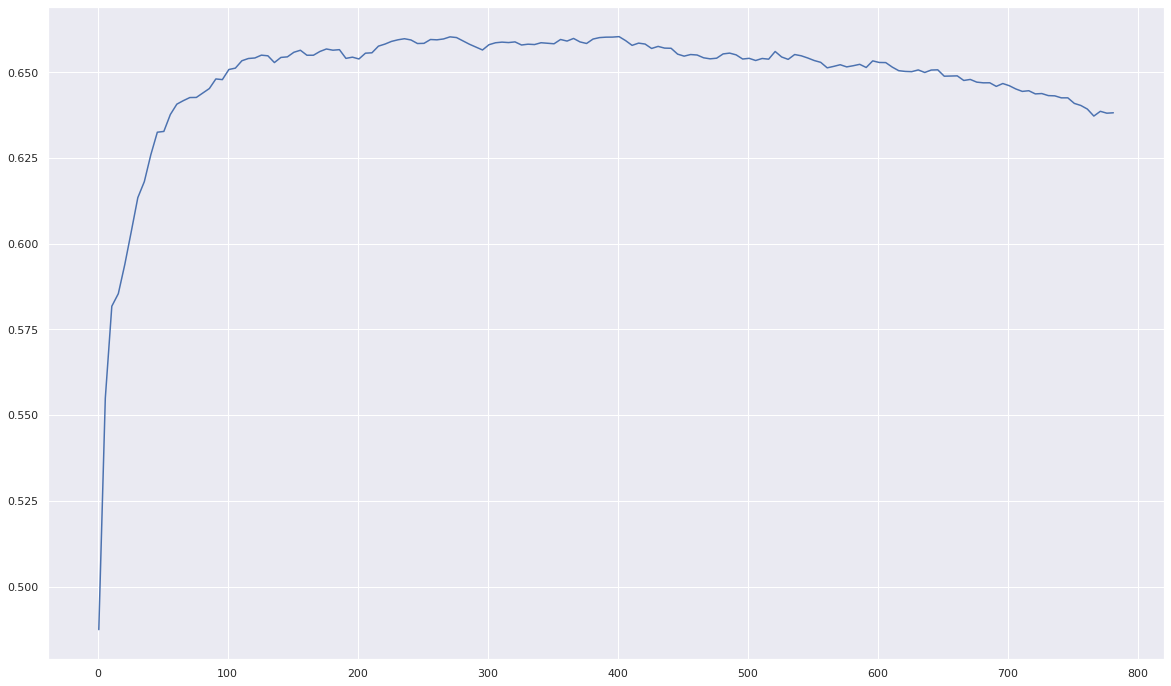

In [ ]:
sns.set(rc={'figure.figsize':(20,12)})
sns.lineplot(data=f1_results_unigram_bigram)

In [ ]:
# Getting the optimal number of features which will result in best mean cross validation F1-score from the dictionary

best_no_of_features= max(f1_results_unigram_bigram, key=f1_results_unigram_bigram.get)
best_no_of_features

401

In [ ]:
# Extracting the optimal number of features into a dataframe for training

chi2_columns = chi2_df_sorted.columns[:best_no_of_features]
X_train_vectorized_unigram_bigram_chi_square = df_vectorized_text_unigrams_and_bigrams_train[chi2_columns]
X_test_vectorized_unigram_bigram_chi_square = df_vectorized_text_unigrams_and_bigrams_test[chi2_columns]

In [ ]:
X_train = X_train_vectorized_unigram_bigram_chi_square
X_test = X_test_vectorized_unigram_bigram_chi_square

clf = LinearSVC(random_state=0).fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
print('Train Accuracy: ' + '{:.2%}'.format(accuracy_score(y_train, y_train_pred)))

y_test_pred = clf.predict(X_test)
print('Test Accuracy: ' + '{:.2%}'.format(accuracy_score(y_test, y_test_pred)))
print('Test F1 Score: ' + '{:.2%}'.format(f1_score(y_test, y_test_pred, average='weighted')))

## Cross Validation
cross_val_accuracy_scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=10, n_jobs=-1)   
print("Mean Cross Val Accuracy: " + '{:.2%}'.format(cross_val_accuracy_scores.mean()))
    
cross_val_f1_scores = cross_val_score(clf, X_train, y_train, scoring='f1_weighted', cv=10, n_jobs=-1)
print("Mean Cross Val F1 Score: " + '{:.2%}'.format(cross_val_f1_scores.mean()))

testing_matthew_coeff = matthews_corrcoef(y_test, y_test_pred)
print("Testing Matthew's coefficient:", round(testing_matthew_coeff,3))

Train Accuracy: 73.13%
Test Accuracy: 70.77%
Test F1 Score: 67.86%
Mean Cross Val Accuracy: 68.88%
Mean Cross Val F1 Score: 65.92%
Testing Matthew's coefficient: 0.394


## Unigrams + Bigrams + Unsupervised Topics Results

In [ ]:
unsupervised_topics=[(1,
  [('california', 0.0676629306766293),
   ('human', 0.034039020340390205),
   ('legal', 0.026151930261519303),
   ('accident', 0.025736820257368204),
   ('hit', 0.024076380240763803),
   ('state', 0.020755500207555),
   ('stop', 0.019925280199252802),
   ('mile', 0.0186799501867995),
   ('insurance', 0.0182648401826484),
   ('wow', 0.015359070153590702),
   ('valley', 0.014943960149439602),
   ('permit', 0.014113740141137402),
   ('testing', 0.0136986301369863),
   ('toyota', 0.0136986301369863),
   ('invent', 0.013283520132835201),
   ('license', 0.013283520132835201),
   ('legalize', 0.012868410128684102),
   ('silicon', 0.012868410128684102),
   ('sign', 0.012038190120381901),
   ('law', 0.011623080116230802),
   ('bill', 0.0112079701120797),
   ('week', 0.010792860107928601),
   ('nevada', 0.009962640099626401),
   ('complete', 0.0091324200913242),
   ('florida', 0.0091324200913242),
   ('approve', 0.0091324200913242),
   ('report', 0.008717310087173101),
   ('release', 0.008717310087173101),
   ('push', 0.008717310087173101),
   ('house', 0.007471980074719801)]),
 (2,
  [('google', 0.17845257903494177),
   ('year', 0.044509151414309486),
   ('thing', 0.04076539101497504),
   ('build', 0.03868552412645591),
   ('buy', 0.0262063227953411),
   ('talk', 0.02454242928452579),
   ('happen', 0.02204658901830283),
   ('start', 0.019966722129783693),
   ('company', 0.017054908485856904),
   ('news', 0.015391014975041598),
   ('mt', 0.014559068219633943),
   ('read', 0.012895174708818636),
   ('detroit', 0.011231281198003328),
   ('seat', 0.011231281198003328),
   ('ceo', 0.010399334442595673),
   ('internet', 0.009983361064891847),
   ('wrong', 0.009983361064891847),
   ('space', 0.009983361064891847),
   ('picture', 0.008735440931780365),
   ('delivery', 0.008319467554076539),
   ('break', 0.008319467554076539),
   ('write', 0.008319467554076539),
   ('corner', 0.0066555740432612314),
   ('drop', 0.0066555740432612314),
   ('nyc', 0.006239600665557404),
   ('fuck', 0.005407653910149751),
   ('wait', 0.005407653910149751),
   ('market', 0.005407653910149751),
   ('automaker', 0.004991680532445923),
   ('tire', 0.004991680532445923)]),
 (3,
  [('future', 0.10693153000845308),
   ('road', 0.08918005071851226),
   ('test', 0.0566356720202874),
   ('good', 0.034657650042265425),
   ('audi', 0.024091293322062553),
   ('drone', 0.021132713440405747),
   ('public', 0.02028740490278952),
   ('truck', 0.01944209636517329),
   ('amazing', 0.016060862214708368),
   ('close', 0.013524936601859678),
   ('computer', 0.011411665257819104),
   ('ce', 0.011411665257819104),
   ('bus', 0.01014370245139476),
   ('reality', 0.01014370245139476),
   ('uk', 0.009721048182586645),
   ('open', 0.008875739644970414),
   ('volvo', 0.008875739644970414),
   ('begin', 0.008030431107354184),
   ('deliver', 0.008030431107354184),
   ('agree', 0.007185122569737954),
   ('blind', 0.006762468300929839),
   ('mercedes', 0.006762468300929839),
   ('deal', 0.006339814032121725),
   ('order', 0.005494505494505495),
   ('fall', 0.005494505494505495),
   ('navigate', 0.005494505494505495),
   ('scary', 0.005494505494505495),
   ('drink', 0.005494505494505495),
   ('amazon', 0.00507185122569738),
   ('benz', 0.00507185122569738)]),
 (4,
  [('people', 0.05048380311316786),
   ('time', 0.04669751787968027),
   ('world', 0.0340765671013883),
   ('auto', 0.030290281867900715),
   ('change', 0.02145561632309634),
   ('safe', 0.02103491796381994),
   ('real', 0.01766933108960875),
   ('fly', 0.01724863273033235),
   ('live', 0.016827934371055953),
   ('feel', 0.015145140933950358),
   ('googles', 0.015145140933950358),
   ('kill', 0.013883045856121162),
   ('point', 0.013462347496844763),
   ('googleplex', 0.013462347496844763),
   ('hear', 0.011358855700462769),
   ('inside', 0.011358855700462769),
   ('finally', 0.010096760622633571),
   ('highway', 0.010096760622633571),
   ('solve', 0.009255363904080775),
   ('googlecar', 0.008834665544804375),
   ('sleep', 0.008413967185527976),
   ('impact', 0.008413967185527976),
   ('infrastructure', 0.007993268826251577),
   ('tweet', 0.007993268826251577),
   ('hard', 0.007572570466975179),
   ('miss', 0.00715187210769878),
   ('late', 0.00715187210769878),
   ('easy', 0.00715187210769878),
   ('algorithm', 0.006731173748422381),
   ('exist', 0.006731173748422381)]),
 (5,
  [('autonomous', 0.12761592121460813),
   ('vehicle', 0.11571604431678292),
   ('driving', 0.04267542059909725),
   ('technology', 0.042265080016413624),
   ('design', 0.02051702913418137),
   ('innovation', 0.016823963890028725),
   ('lexus', 0.014361920393926959),
   ('automate', 0.013130898645876077),
   ('control', 0.012310217480508822),
   ('dmv', 0.010668855149774312),
   ('industry', 0.009848173984407058),
   ('rule', 0.009848173984407058),
   ('forward', 0.009848173984407058),
   ('death', 0.00943783340172343),
   ('lead', 0.009027492819039803),
   ('fully', 0.007796471070988921),
   ('hate', 0.007796471070988921),
   ('article', 0.007386130488305293),
   ('la', 0.006975789905621666),
   ('automobile', 0.006565449322938038),
   ('center', 0.006565449322938038),
   ('damn', 0.006155108740254411),
   ('connected', 0.006155108740254411),
   ('concept', 0.006155108740254411),
   ('automotive', 0.005744768157570784),
   ('mode', 0.005334427574887156),
   ('food', 0.005334427574887156),
   ('driverlesscar', 0.005334427574887156),
   ('reduce', 0.004924086992203529),
   ('small', 0.004924086992203529)]),
 (6,
  [('google', 0.26324859974149073),
   ('today', 0.05040930633347695),
   ('pass', 0.034898750538560966),
   ('ready', 0.03059026281775097),
   ('spot', 0.024989228780697974),
   ('hope', 0.02240413614821198),
   ('find', 0.017664799655320983),
   ('day', 0.017664799655320983),
   ('save', 0.014648858250753986),
   ('end', 0.013787160706591986),
   ('commute', 0.009478672985781991),
   ('goog', 0.00904782421370099),
   ('san', 0.008616975441619991),
   ('yeah', 0.008616975441619991),
   ('follow', 0.008616975441619991),
   ('play', 0.007755277897457992),
   ('freeway', 0.007755277897457992),
   ('problem', 0.007755277897457992),
   ('excited', 0.007755277897457992),
   ('kid', 0.007324429125376993),
   ('person', 0.006893580353295993),
   ('man', 0.006462731581214994),
   ('cost', 0.005601034037052995),
   ('movie', 0.005170185264971995),
   ('regulation', 0.004739336492890996),
   ('important', 0.004739336492890996),
   ('eliminate', 0.004308487720809996),
   ('block', 0.004308487720809996),
   ('claim', 0.004308487720809996),
   ('low', 0.004308487720809996)]),
 (7,
  [('great', 0.030146425495262703),
   ('tesla', 0.025409130060292853),
   ('idea', 0.020671834625323),
   ('awesome', 0.019810508182601206),
   ('day', 0.01636520241171404),
   ('home', 0.01636520241171404),
   ('pic', 0.01636520241171404),
   ('develop', 0.015073212747631352),
   ('create', 0.014642549526270457),
   ('lol', 0.014642549526270457),
   ('safety', 0.013781223083548665),
   ('electric', 0.013350559862187769),
   ('roll', 0.013350559862187769),
   ('train', 0.013350559862187769),
   ('problem', 0.012919896640826873),
   ('business', 0.012489233419465978),
   ('imagine', 0.012058570198105082),
   ('race', 0.011627906976744186),
   ('system', 0.011627906976744186),
   ('transit', 0.01119724375538329),
   ('guy', 0.010766580534022395),
   ('true', 0.010766580534022395),
   ('dream', 0.010766580534022395),
   ('datum', 0.009905254091300603),
   ('robotic', 0.009905254091300603),
   ('drunk', 0.009474590869939707),
   ('challenge', 0.009474590869939707),
   ('cruise', 0.00904392764857881),
   ('mass', 0.008613264427217916),
   ('story', 0.00818260120585702)]),
 (8,
  [('uber', 0.07060333761232349),
   ('ride', 0.04321780059905862),
   ('taxi', 0.03508771929824561),
   ('watch', 0.03080872913992298),
   ('google', 0.025673940949935817),
   ('park', 0.018827556696619598),
   ('parking', 0.01797175866495507),
   ('lot', 0.01797175866495507),
   ('bad', 0.015832263585793753),
   ('job', 0.014548566538296961),
   ('phone', 0.014548566538296961),
   ('video', 0.014120667522464698),
   ('fleet', 0.012836970474967908),
   ('place', 0.01069747539580659),
   ('replace', 0.010269576379974325),
   ('launch', 0.010269576379974325),
   ('model', 0.009841677364142062),
   ('pay', 0.009841677364142062),
   ('cab', 0.008985879332477536),
   ('pick', 0.008985879332477536),
   ('sf', 0.008985879332477536),
   ('fbi', 0.008985879332477536),
   ('cyclist', 0.008985879332477536),
   ('ad', 0.008557980316645272),
   ('guess', 0.008130081300813009),
   ('reason', 0.008130081300813009),
   ('reshape', 0.007702182284980745),
   ('share', 0.007702182284980745),
   ('require', 0.007274283269148481),
   ('economy', 0.0068463842533162175)]),
 (9,
  [('tech', 0.04965753424657534),
   ('robot', 0.03424657534246575),
   ('traffic', 0.030393835616438356),
   ('apple', 0.026541095890410957),
   ('glass', 0.019691780821917807),
   ('plan', 0.019263698630136987),
   ('nissan', 0.018835616438356163),
   ('trust', 0.0175513698630137),
   ('question', 0.0136986301369863),
   ('bring', 0.013270547945205479),
   ('free', 0.012414383561643835),
   ('announce', 0.011558219178082191),
   ('drivingcar', 0.01113013698630137),
   ('research', 0.009845890410958904),
   ('morning', 0.009417808219178082),
   ('set', 0.00898972602739726),
   ('camera', 0.00898972602739726),
   ('nice', 0.008561643835616438),
   ('bmw', 0.008133561643835616),
   ('run', 0.008133561643835616),
   ('gm', 0.008133561643835616),
   ('stuff', 0.007705479452054794),
   ('tv', 0.007277397260273972),
   ('learn', 0.006421232876712328),
   ('age', 0.006421232876712328),
   ('add', 0.006421232876712328),
   ('wearable', 0.0059931506849315065),
   ('child', 0.0059931506849315065),
   ('bet', 0.005565068493150685),
   ('trend', 0.005565068493150685)]),
 (10,
  [('google', 0.2402120717781403),
   ('street', 0.05831973898858075),
   ('wheel', 0.050978792822185974),
   ('steering', 0.035481239804241435),
   ('view', 0.029771615008156605),
   ('city', 0.02732463295269168),
   ('unveil', 0.01957585644371941),
   ('prototype', 0.017128874388254486),
   ('hand', 0.016721044045676998),
   ('brake', 0.015497553017944535),
   ('mountain', 0.014274061990212071),
   ('pedal', 0.013866231647634585),
   ('master', 0.01101141924959217),
   ('codecon', 0.00897226753670473),
   ('search', 0.00734094616639478),
   ('meet', 0.00734094616639478),
   ('perfect', 0.0065252854812398045),
   ('glass', 0.006117455138662317),
   ('button', 0.006117455138662317),
   ('sit', 0.006117455138662317),
   ('campus', 0.005709624796084829),
   ('past', 0.005709624796084829),
   ('gas', 0.005301794453507341),
   ('social', 0.004893964110929853),
   ('billion', 0.004893964110929853),
   ('fill', 0.004486133768352365),
   ('development', 0.004486133768352365),
   ('yay', 0.004078303425774877),
   ('siliconvalley', 0.004078303425774877),
   ('location', 0.004078303425774877)]),
 (11,
  [('wait', 0.046052631578947366),
   ('nt', 0.04429824561403509),
   ('life', 0.02456140350877193),
   ('transportation', 0.02149122807017544),
   ('city', 0.019736842105263157),
   ('long', 0.018421052631578946),
   ('interesting', 0.017105263157894738),
   ('crash', 0.015789473684210527),
   ('turn', 0.015789473684210527),
   ('speed', 0.015350877192982455),
   ('government', 0.013157894736842105),
   ('fun', 0.012280701754385965),
   ('michigan', 0.012280701754385965),
   ('issue', 0.011842105263157895),
   ('head', 0.011842105263157895),
   ('service', 0.011842105263157895),
   ('ticket', 0.011403508771929825),
   ('hour', 0.011403508771929825),
   ('lane', 0.010964912280701754),
   ('hey', 0.010526315789473684),
   ('office', 0.010526315789473684),
   ('program', 0.010526315789473684),
   ('light', 0.010087719298245614),
   ('study', 0.010087719298245614),
   ('sound', 0.009649122807017544),
   ('run', 0.009210526315789473),
   ('ann', 0.009210526315789473),
   ('arbor', 0.009210526315789473),
   ('pull', 0.009210526315789473),
   ('university', 0.009210526315789473)]),
 (12,
  [('google', 0.20894909688013136),
   ('work', 0.05213464696223317),
   ('cool', 0.050492610837438424),
   ('map', 0.021346469622331693),
   ('love', 0.020114942528735632),
   ('big', 0.020114942528735632),
   ('pretty', 0.017651888341543513),
   ('ford', 0.01683087027914614),
   ('fast', 0.013136288998357963),
   ('project', 0.013136288998357963),
   ('step', 0.011904761904761904),
   ('video', 0.011083743842364532),
   ('shit', 0.010262725779967159),
   ('worth', 0.009441707717569787),
   ('totally', 0.0090311986863711),
   ('check', 0.008620689655172414),
   ('team', 0.008210180623973728),
   ('crazy', 0.007799671592775041),
   ('area', 0.007799671592775041),
   ('thought', 0.007389162561576354),
   ('trillion', 0.0069786535303776685),
   ('arrive', 0.006157635467980296),
   ('super', 0.006157635467980296),
   ('line', 0.006157635467980296),
   ('omg', 0.005747126436781609),
   ('figure', 0.005336617405582923),
   ('reveal', 0.005336617405582923),
   ('stanford', 0.0049261083743842365),
   ('software', 0.0049261083743842365),
   ('app', 0.0049261083743842365)])]

df_train_unsupervised_unigram_bigram=df.copy()
df_test_unsupervised_unigram_bigram=df_test.copy()

def assign_topic_score(text, topic_no):
    topic_list=unsupervised_topics[topic_no-1][1]    
    
    wordlist=text.split(' ')
    topic_score=0
    for word in wordlist:
        for word_weight in topic_list:
            if word==word_weight[0]:
                topic_score+=word_weight[1]
                
    return topic_score
    
for each_topic in unsupervised_topics:
    df_train_unsupervised_unigram_bigram['unsupervised_topic_' + str(each_topic[0])]= df_train_unsupervised_unigram_bigram.apply(lambda row: assign_topic_score(row['lemmatized and stopwords_removed'], each_topic[0]), axis=1)
    df_test_unsupervised_unigram_bigram['unsupervised_topic_' + str(each_topic[0])]= df_test_unsupervised_unigram_bigram.apply(lambda row: assign_topic_score(row['lemmatized and stopwords_removed'], each_topic[0]), axis=1)


## Training without Chi Square Feature Selection

## Preparing data for model training

In [ ]:
# Scaling the Unsupervised topics

scaler = MinMaxScaler()
scaled_train_unsupervised_unigram_bigram = scaler.fit_transform(df_train_unsupervised_unigram_bigram.iloc[:, 3:])
scaled_test_unsupervised_unigram_bigram = scaler.transform(df_test_unsupervised_unigram_bigram.iloc[:, 3:])

# Transforming scaled topics into a dataframe

scaled_train_unsupervised_unigram_bigram_df = pd.DataFrame(scaled_train_unsupervised_unigram_bigram, columns = df_train_unsupervised_unigram_bigram.iloc[:, 3:].columns)
scaled_test_unsupervised_unigram_bigram_df = pd.DataFrame(scaled_test_unsupervised_unigram_bigram, columns = df_test_unsupervised_unigram_bigram.iloc[:, 3:].columns)

# Combining Unigrams + Bigrams + Unsupervised topics into one dataframe

train_unsupervised_unigram_bigram = pd.concat([scaled_train_unsupervised_unigram_bigram_df, df_vectorized_text_unigrams_and_bigrams_train], axis=1)
test_unsupervised_unigram_bigram = pd.concat([scaled_test_unsupervised_unigram_bigram_df, df_vectorized_text_unigrams_and_bigrams_test], axis=1)

In [ ]:
X_train = train_unsupervised_unigram_bigram
X_test = test_unsupervised_unigram_bigram

clf = LinearSVC(random_state=0).fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
print('Train Accuracy: ' + '{:.2%}'.format(accuracy_score(y_train, y_train_pred)))

y_test_pred = clf.predict(X_test)
print('Test Accuracy: ' + '{:.2%}'.format(accuracy_score(y_test, y_test_pred)))
print('Test F1 Score: ' + '{:.2%}'.format(f1_score(y_test, y_test_pred, average='weighted')))

## Cross Validation
cross_val_accuracy_scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=10, n_jobs=-1)   
print("Mean Cross Val Accuracy: " + '{:.2%}'.format(cross_val_accuracy_scores.mean()))
    
cross_val_f1_scores = cross_val_score(clf, X_train, y_train, scoring='f1_weighted', cv=10, n_jobs=-1)
print("Mean Cross Val F1 Score: " + '{:.2%}'.format(cross_val_f1_scores.mean()))

testing_matthew_coeff = matthews_corrcoef(y_test, y_test_pred)
print("Testing Matthew's coefficient:", round(testing_matthew_coeff,3))

Train Accuracy: 75.17%
Test Accuracy: 70.17%
Test F1 Score: 67.60%
Mean Cross Val Accuracy: 66.68%
Mean Cross Val F1 Score: 64.01%
Testing Matthew's coefficient: 0.385


## Training with Chi Square Feature Selection

## Preparing data for model training

In [ ]:
# Scaling the Unsupervised topics

scaler = MinMaxScaler()
scaled_train_unsupervised_unigram_bigram_chi_square = scaler.fit_transform(df_train_unsupervised_unigram_bigram.iloc[:, 3:])
scaled_test_unsupervised_unigram_bigram_chi_square = scaler.transform(df_test_unsupervised_unigram_bigram.iloc[:, 3:])

# Transforming scaled topics into a dataframe

scaled_train_unsupervised_unigram_bigram_chi_square_df = pd.DataFrame(scaled_train_unsupervised_unigram_bigram_chi_square, columns = df_train_unsupervised_unigram_bigram.iloc[:, 3:].columns)
scaled_test_unsupervised_unigram_bigram_chi_square_df = pd.DataFrame(scaled_test_unsupervised_unigram_bigram_chi_square, columns = df_test_unsupervised_unigram_bigram.iloc[:, 3:].columns)

# Combining Unigrams + Bigrams + Unsupervised topics into one dataframe

train_unsupervised_unigram_bigram_chi_square_df = pd.concat([scaled_train_unsupervised_unigram_bigram_chi_square_df, df_vectorized_text_unigrams_and_bigrams_train], axis=1)
test_unsupervised_unigram_bigram_chi_square_df = pd.concat([scaled_test_unsupervised_unigram_bigram_chi_square_df, df_vectorized_text_unigrams_and_bigrams_test], axis=1)

In [ ]:
# 0 is chi2 score, 1 is p-value
X_train = train_unsupervised_unigram_bigram_chi_square_df
X_test = test_unsupervised_unigram_bigram_chi_square_df

chi2_values = chi2(X_train.values, y_train)
chi2_df = pd.DataFrame(data=chi2_values, columns=X_train.columns)
chi2_df_sorted = chi2_df.sort_values(by=0, axis = 1, ascending = False)
chi2_df_sorted

,cool,wait,want,awesome,amazing,wait self,love,concern,fbi,trust,wow,worry,car cool,problem,weapon,want self,excited,major,point,want driverless,pretty,need self,car awesome,hurry,idea,car use,need,forward,safe,job,pretty cool,unsupervised_topic_11,shit,look forward,omg,wish,car think,commute,exciting,people,...,transport,use google,cut,news,city street,little,drive electric,car park,billion,legal california,work,interesting,game,free,rt self,hear,got,fly,term,google driver,sxsw,track,car roll,cyclist,promise,seat,push,miss,true,driverless taxi,car change,ok,google glass,likely,yr,add,possible,taxi,car like,location
0,7.462667e+01,3.889458e+01,3.443642e+01,3.309590e+01,26.974116,26.902897,26.822298,26.010385,24.685814,23.715714,23.308604,22.045785,21.973334,21.658489,21.277351,20.793491,19.860080,19.330741,16.168061,15.444918,14.989211,14.855761,14.812453,14.537904,14.379446,14.359394,13.934135,13.763880,13.736109,13.660698,13.642506,13.282153,13.262700,12.813253,12.695199,12.62937,12.295087,12.204779,11.828294,11.508387,...,0.125834,0.124250,0.122513,0.118897,0.117932,0.114434,0.112437,0.111721,0.111483,0.110654,0.110425,0.107579,0.106555,0.102144,0.101482,0.099127,0.095429,0.092547,0.091737,0.082413,0.079252,0.077253,0.075914,0.066532,0.060718,0.050673,0.049081,0.043488,0.033119,0.031972,0.027868,0.027175,0.023337,0.022157,0.019299,0.016209,0.015285,0.012621,0.010937,0.000325
1,6.237707e-17,3.582203e-09,3.328329e-08,6.506025e-08,0.000001,0.000001,0.000001,0.000002,0.000004,0.000007,0.000009,0.000016,0.000017,0.000020,0.000024,0.000031,0.000049,0.000063,0.000308,0.000443,0.000556,0.000594,0.000607,0.000697,0.000754,0.000762,0.000942,0.001026,0.001040,0.001080,0.001090,0.001306,0.001318,0.001651,0.001751,0.00181,0.002139,0.002238,0.002701,0.003169,...,0.939021,0.939765,0.940582,0.942284,0.942739,0.944389,0.945332,0.945671,0.945784,0.946176,0.946284,0.947632,0.948117,0.950210,0.950525,0.951645,0.953406,0.954781,0.955167,0.959631,0.961149,0.962110,0.962754,0.967281,0.970097,0.974982,0.975758,0.978491,0.983577,0.984141,0.986163,0.986504,0.988399,0.988983,0.990397,0.991928,0.992387,0.993710,0.994546,0.999837


## Finding the optimal number of features to use based on cross validation F1-score

In [ ]:
f1_results_unsupervised_unigram_bigram_chi_square = {}
for n in range(1, 797, 5):
    chi2_columns_unsupervised_unigram_bigram = chi2_df_sorted.columns[:n]
    X_train_df = train_unsupervised_unigram_bigram_chi_square_df[chi2_columns_unsupervised_unigram_bigram]

    #train MLR
    clf = LinearSVC(random_state=0)

    #Cross validation, cv=5
    f1 = cross_val_score(clf, X_train_df, y_train, scoring='f1_weighted', cv=5)
    
    #Storing mean cross validation F1-scores in a dictionary
    f1_results_unsupervised_unigram_bigram_chi_square[n] = f1.mean() 

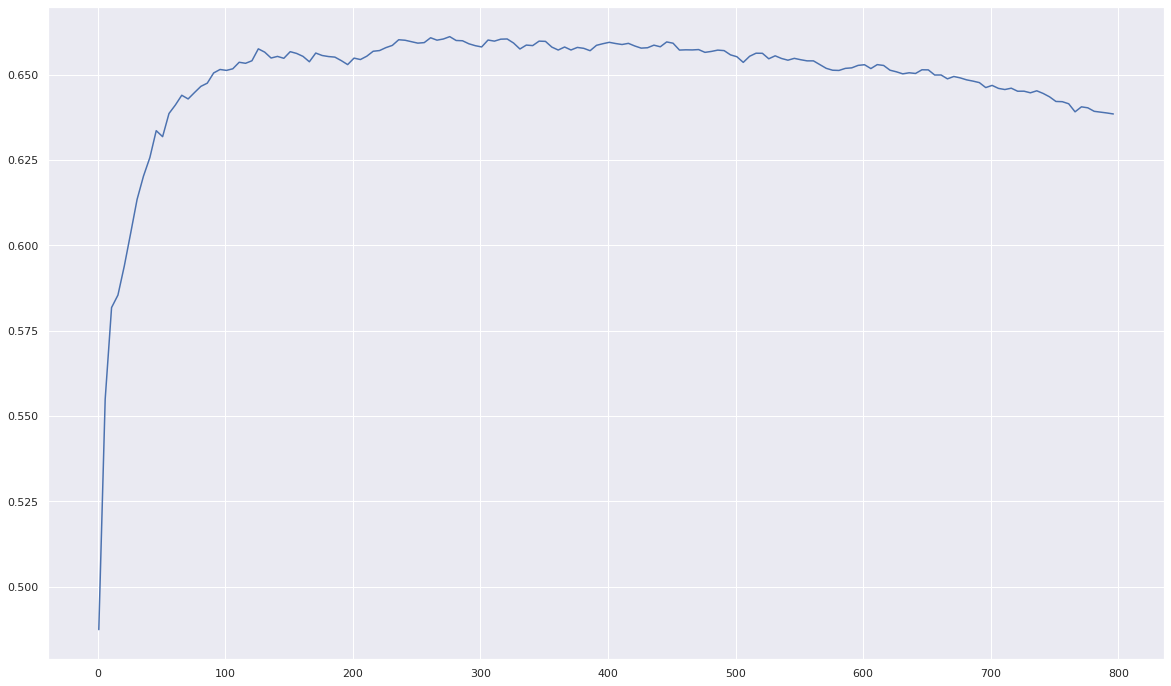

In [ ]:
sns.set(rc={'figure.figsize':(20,12)})
sns.lineplot(data=f1_results_unsupervised_unigram_bigram_chi_square)

In [ ]:
# Getting the optimal number of features which will result in best mean cross validation F1-score from the dictionary

best_no_of_features= max(f1_results_unsupervised_unigram_bigram_chi_square, key=f1_results_unsupervised_unigram_bigram_chi_square.get)
best_no_of_features

276

In [ ]:
# Extracting the optimal number of features into a dataframe for training

chi2_columns = chi2_df_sorted.columns[:best_no_of_features]
scaled_train_unsupervised_unigram_bigram_df_chi_square = train_unsupervised_unigram_bigram_chi_square_df[chi2_columns]
scaled_test_unsupervised_unigram_bigram_df_chi_square = test_unsupervised_unigram_bigram_chi_square_df[chi2_columns]

In [ ]:
X_train = scaled_train_unsupervised_unigram_bigram_df_chi_square
X_test = scaled_test_unsupervised_unigram_bigram_df_chi_square

clf = LinearSVC(random_state=0).fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
print('Train Accuracy: ' + '{:.2%}'.format(accuracy_score(y_train, y_train_pred)))

y_test_pred = clf.predict(X_test)
print('Test Accuracy: ' + '{:.2%}'.format(accuracy_score(y_test, y_test_pred)))
print('Test F1 Score: ' + '{:.2%}'.format(f1_score(y_test, y_test_pred, average='weighted')))

## Cross Validation
cross_val_accuracy_scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=10, n_jobs=-1)   
print("Mean Cross Val Accuracy: " + '{:.2%}'.format(cross_val_accuracy_scores.mean()))
    
cross_val_f1_scores = cross_val_score(clf, X_train, y_train, scoring='f1_weighted', cv=10, n_jobs=-1)
print("Mean Cross Val F1 Score: " + '{:.2%}'.format(cross_val_f1_scores.mean()))

testing_matthew_coeff = matthews_corrcoef(y_test, y_test_pred)
print("Testing Matthew's coefficient:", round(testing_matthew_coeff,3))

Train Accuracy: 72.37%
Test Accuracy: 70.92%
Test F1 Score: 67.94%
Mean Cross Val Accuracy: 69.01%
Mean Cross Val F1 Score: 65.82%
Testing Matthew's coefficient: 0.396


## Unigrams + Bigrams + Supervised topics Results

In [ ]:
# These topics are generated manually by observing highest frequency words.

def accident(text):
    wordlist=['die', 'death', 'kill', 'hit', 'crash', 'accident', 'insurance', 'drunk', 'drink', 'safety', 'speed', 'limit']
    words=text.split(' ')
    for word in words:
        if word in wordlist:
            return 1
    return 0

def change(text):
    wordlist=['change', 'replace', 'become', 'happen', 'transform']
    words=text.split(' ')
    for word in words:
        if word in wordlist:
            return 1
    return 0

def imagination_vs_reality(text):
    wordlist= ['reality', 'dream', 'imagine', 'imagination', 'challenge']
    words=text.split(' ')
    for word in words:
        if word in wordlist:
            return 1
    return 0

def law(text):
    wordlist=['policy', 'law', 'legal', 'government', 'state', 'regulation', 'license', 'approve', 'allow', 'rule', 
              'public']
    words=text.split(' ')
    for word in words:
        if word in wordlist:
            return 1
    return 0

def time(text):
    wordlist=['future', 'today', 'next', 'year', 'past', 'world']
    words=text.split(' ')
    for word in words:
        if word in wordlist:
            return 1
    return 0

def technology(text):
    wordlist=['technology', 'tech', 'robot', 'drone', 'machine', 'computer', 'robotic', 'program', 'ai', 'automobile', 
              'electric', 'system', 'information', 'data', 'automate']
    words=text.split(' ')
    for word in words:
        if word in wordlist:
            return 1
    return 0

def innovation(text):
    wordlist=['research', 'invent', 'innovation', 'innovate', 'invention', 'breakthrough', 'idea', 'develop', 
              'create', 'prototype', 'develop', 'build']
    words=text.split(' ')
    for word in words:
        if word in wordlist:
            return 1
    return 0

def business(text):
    wordlist=['money', 'invest', 'market', 'ceo', 'cost', 'buy', 'business', 'company']
    words=text.split(' ')
    for word in words:
        if word in wordlist:
            return 1
    return 0


def positive_words(text):
    wordlist=['get', 'want', 'cool', 'good', 'great', 'love', 'awesome', 'wow', 'perfect', 'solve', 'solution', 
              'excite', 'fun', 'safe', 'help', 'best', 'hope', 'lead']
              
    double_words=['look forward', 'cant wait']
    
    count=0
    words=text.split(' ')
    for word in words:
        if word in wordlist:
            count+=1
            wordlist.remove(word)
    
    for phrase in double_words:
        if phrase in text:
            count+=1
              
    return count
              
              

def bad_words(text):
    wordlist=['never', 'fuck', 'shit', 'hell', 'scary', 'wtf', 'freak', 'hate', 'wrong', 'worry', 'die', 
              'kill', 'bad', 'crazy', 'death', 'problem', 'dangerous']
    count=0
    words=text.split(' ')
    for word in words:
        if word in wordlist:
            count+=1
            wordlist.remove(word)
    
    return count


#brands/places/transportation type/events/products
columns=['toyota', 'audi', 'tesla', 'apple', 'google', 'uber', 'ford', 'lexus', 'nissan', 'volvo', 'bmw', 'california', 
         'michigan', 'detroit', 'googleplex', 'dmv', 'ce', 'codecon', 'forbes', 
         'cnet', 'wsj', 'train', 'railway', 'cruise', 'road', 'taxi', 'truck', 'highway', 'bus', 'cab', 'bike', 'freeway',
         'googlecar', 'camera', 'ego']

double_words=['ann arbor', 'silicon valley', 'google map', 'google glass']

def get_column_value(text, word):
    wordlist=text.split(' ')
    if word in wordlist:
        return 1
    return 0

def get_double_value(text, phrase):
    if phrase in text:
        return 1
    return 0

In [ ]:
df_train_supervised_unigram_bigram=df.copy()
df_test_supervised_unigram_bigram=df_test.copy()

In [ ]:
for word in columns:
    df_train_supervised_unigram_bigram['topic ' + word]=df_train_supervised_unigram_bigram.apply(lambda x: get_column_value(x['lemmatized and stopwords_removed'], word), axis=1)
    df_test_supervised_unigram_bigram['topic ' + word]=df_test_supervised_unigram_bigram.apply(lambda x: get_column_value(x['lemmatized and stopwords_removed'], word), axis=1)
for phrase in double_words:
    df_train_supervised_unigram_bigram['topic ' + phrase]=df_train_supervised_unigram_bigram.apply(lambda x: get_double_value(x['lemmatized and stopwords_removed'], phrase), axis=1)
    df_test_supervised_unigram_bigram['topic ' + phrase]=df_test_supervised_unigram_bigram.apply(lambda x: get_column_value(x['lemmatized and stopwords_removed'], word), axis=1)

In [ ]:
# train dataset
df_train_supervised_unigram_bigram['topic accident']= df_train_supervised_unigram_bigram['lemmatized and stopwords_removed'].apply(accident)
df_train_supervised_unigram_bigram['topic change']= df_train_supervised_unigram_bigram['lemmatized and stopwords_removed'].apply(change)
df_train_supervised_unigram_bigram['topic imagination_vs_reality']= df_train_supervised_unigram_bigram['lemmatized and stopwords_removed'].apply(imagination_vs_reality)
df_train_supervised_unigram_bigram['topic law']= df_train_supervised_unigram_bigram['lemmatized and stopwords_removed'].apply(law)
df_train_supervised_unigram_bigram['topic time']= df_train_supervised_unigram_bigram['lemmatized and stopwords_removed'].apply(time)
df_train_supervised_unigram_bigram['topic technology']= df_train_supervised_unigram_bigram['lemmatized and stopwords_removed'].apply(technology)
df_train_supervised_unigram_bigram['topic innovation']= df_train_supervised_unigram_bigram['lemmatized and stopwords_removed'].apply(innovation)
df_train_supervised_unigram_bigram['topic business']= df_train_supervised_unigram_bigram['lemmatized and stopwords_removed'].apply(business)

df_train_supervised_unigram_bigram['topic positive_words']= df_train_supervised_unigram_bigram['lemmatized and stopwords_removed'].apply(positive_words)
df_train_supervised_unigram_bigram['topic bad_words']= df_train_supervised_unigram_bigram['lemmatized and stopwords_removed'].apply(bad_words)
df_train_supervised_unigram_bigram['topic net positive']=df_train_supervised_unigram_bigram['topic positive_words']-df_train_supervised_unigram_bigram['topic bad_words']

# test dataset

df_test_supervised_unigram_bigram['topic accident']= df_test_supervised_unigram_bigram['lemmatized and stopwords_removed'].apply(accident)
df_test_supervised_unigram_bigram['topic change']= df_test_supervised_unigram_bigram['lemmatized and stopwords_removed'].apply(change)
df_test_supervised_unigram_bigram['topic imagination_vs_reality']= df_test_supervised_unigram_bigram['lemmatized and stopwords_removed'].apply(imagination_vs_reality)
df_test_supervised_unigram_bigram['topic law']= df_test_supervised_unigram_bigram['lemmatized and stopwords_removed'].apply(law)
df_test_supervised_unigram_bigram['topic time']= df_test_supervised_unigram_bigram['lemmatized and stopwords_removed'].apply(time)
df_test_supervised_unigram_bigram['topic technology']= df_test_supervised_unigram_bigram['lemmatized and stopwords_removed'].apply(technology)
df_test_supervised_unigram_bigram['topic innovation']= df_test_supervised_unigram_bigram['lemmatized and stopwords_removed'].apply(innovation)
df_test_supervised_unigram_bigram['topic business']= df_test_supervised_unigram_bigram['lemmatized and stopwords_removed'].apply(business)

df_test_supervised_unigram_bigram['topic positive_words']= df_test_supervised_unigram_bigram['lemmatized and stopwords_removed'].apply(positive_words)
df_test_supervised_unigram_bigram['topic bad_words']= df_test_supervised_unigram_bigram['lemmatized and stopwords_removed'].apply(bad_words)
df_test_supervised_unigram_bigram['topic net positive']=df_test_supervised_unigram_bigram['topic positive_words']-df_test_supervised_unigram_bigram['topic bad_words']

## Training without Chi Square Feature Selection

## Preparing data for model training

In [ ]:
# Scaling the Supervised topics

scaler = MinMaxScaler()
scaled_train_supervised_unigram_bigram = scaler.fit_transform(df_train_supervised_unigram_bigram.iloc[:, 3:])
scaled_test_supervised_unigram_bigram = scaler.transform(df_test_supervised_unigram_bigram.iloc[:, 3:])

# Transforming scaled topics into a dataframe

scaled_train_supervised_unigram_bigram_df = pd.DataFrame(scaled_train_supervised_unigram_bigram, columns = df_train_supervised_unigram_bigram.iloc[:, 3:].columns)
scaled_test_supervised_unigram_bigram_df = pd.DataFrame(scaled_test_supervised_unigram_bigram, columns = df_test_supervised_unigram_bigram.iloc[:, 3:].columns)

# Combining Unigrams + Bigrams + Unsupervised topics into one dataframe

train_supervised_unigram_bigram = pd.concat([scaled_train_supervised_unigram_bigram_df, df_vectorized_text_unigrams_and_bigrams_train], axis=1)
test_supervised_unigram_bigram = pd.concat([scaled_test_supervised_unigram_bigram_df, df_vectorized_text_unigrams_and_bigrams_test], axis=1)

In [ ]:
X_train = train_supervised_unigram_bigram
X_test = test_supervised_unigram_bigram

clf = LinearSVC(random_state=0).fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
print('Train Accuracy: ' + '{:.2%}'.format(accuracy_score(y_train, y_train_pred)))

y_test_pred = clf.predict(X_test)
print('Test Accuracy: ' + '{:.2%}'.format(accuracy_score(y_test, y_test_pred)))
print('Test F1 Score: ' + '{:.2%}'.format(f1_score(y_test, y_test_pred, average='weighted')))

## Cross Validation
cross_val_accuracy_scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=10, n_jobs=-1)   
print("Mean Cross Val Accuracy: " + '{:.2%}'.format(cross_val_accuracy_scores.mean()))
    
cross_val_f1_scores = cross_val_score(clf, X_train, y_train, scoring='f1_weighted', cv=10, n_jobs=-1)
print("Mean Cross Val F1 Score: " + '{:.2%}'.format(cross_val_f1_scores.mean()))

testing_matthew_coeff = matthews_corrcoef(y_test, y_test_pred)
print("Testing Matthew's coefficient:", round(testing_matthew_coeff,3))

Train Accuracy: 75.43%
Test Accuracy: 69.80%
Test F1 Score: 67.34%
Mean Cross Val Accuracy: 66.74%
Mean Cross Val F1 Score: 64.11%
Testing Matthew's coefficient: 0.378


With regularization

In [ ]:
X_train = train_supervised_unigram_bigram
X_test = test_supervised_unigram_bigram

clf = LinearSVC(random_state=0, C=0.5).fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
print('Train Accuracy: ' + '{:.2%}'.format(accuracy_score(y_train, y_train_pred)))

y_test_pred = clf.predict(X_test)
print('Test Accuracy: ' + '{:.2%}'.format(accuracy_score(y_test, y_test_pred)))
print('Test F1 Score: ' + '{:.2%}'.format(f1_score(y_test, y_test_pred, average='weighted')))

## Cross Validation
cross_val_accuracy_scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=10, n_jobs=-1)   
print("Mean Cross Val Accuracy: " + '{:.2%}'.format(cross_val_accuracy_scores.mean()))
    
cross_val_f1_scores = cross_val_score(clf, X_train, y_train, scoring='f1_weighted', cv=10, n_jobs=-1)
print("Mean Cross Val F1 Score: " + '{:.2%}'.format(cross_val_f1_scores.mean()))

testing_matthew_coeff = matthews_corrcoef(y_test, y_test_pred)
print("Testing Matthew's coefficient:", round(testing_matthew_coeff,3))

Train Accuracy: 74.68%
Test Accuracy: 70.69%
Test F1 Score: 68.00%
Mean Cross Val Accuracy: 67.39%
Mean Cross Val F1 Score: 64.25%
Testing Matthew's coefficient: 0.394


## Training with Chi Square Feature Selection

## Preparing data for model training

In [ ]:
# Scaling the Supervised topics

scaler = MinMaxScaler()
scaled_train_supervised_unigram_bigram_chi_square = scaler.fit_transform(df_train_supervised_unigram_bigram.iloc[:, 3:])
scaled_test_supervised_unigram_bigram_chi_square = scaler.transform(df_test_supervised_unigram_bigram.iloc[:, 3:])

# Transforming scaled topics into a dataframe

scaled_train_supervised_unigram_bigram_chi_square_df = pd.DataFrame(scaled_train_supervised_unigram_bigram_chi_square, columns = df_train_supervised_unigram_bigram.iloc[:, 3:].columns)
scaled_test_supervised_unigram_bigram_chi_square_df = pd.DataFrame(scaled_test_supervised_unigram_bigram_chi_square, columns = df_test_supervised_unigram_bigram.iloc[:, 3:].columns)

# Combining Unigrams + Bigrams + Unsupervised topics into one dataframe

train_supervised_unigram_bigram_chi_square_df = pd.concat([scaled_train_supervised_unigram_bigram_chi_square_df, df_vectorized_text_unigrams_and_bigrams_train], axis=1)
test_supervised_unigram_bigram_chi_square_df = pd.concat([scaled_test_supervised_unigram_bigram_chi_square_df, df_vectorized_text_unigrams_and_bigrams_test], axis=1)

In [ ]:
# 0 is chi2 score, 1 is p-value
X_train = train_supervised_unigram_bigram_chi_square_df
X_test = test_supervised_unigram_bigram_chi_square_df

chi2_values = chi2(X_train.values, y_train)
chi2_df = pd.DataFrame(data=chi2_values, columns=X_train.columns)
chi2_df_sorted = chi2_df.sort_values(by=0, axis = 1, ascending = False)
chi2_df_sorted

,topic positive_words,cool,topic bad_words,wait,want,awesome,amazing,wait self,love,concern,topic accident,fbi,trust,wow,worry,car cool,problem,weapon,want self,excited,major,topic law,point,topic michigan,want driverless,pretty,need self,car awesome,topic bus,hurry,idea,car use,topic california,topic detroit,need,topic toyota,forward,safe,job,pretty cool,...,news,city street,little,drive electric,car park,billion,legal california,work,interesting,game,free,rt self,hear,got,fly,term,google driver,sxsw,track,car roll,cyclist,promise,seat,push,topic google glass,miss,true,driverless taxi,car change,ok,google glass,likely,yr,add,possible,taxi,car like,location,topic forbes,topic ego
0,1.673048e+02,7.462667e+01,6.948604e+01,3.889458e+01,3.443642e+01,3.309590e+01,26.974116,26.902897,26.822298,26.010385,24.950886,24.685814,23.715714,23.308604,22.045785,21.973334,21.658489,21.277351,20.793491,19.860080,19.330741,17.541870,16.168061,15.601755,15.444918,14.989211,14.855761,14.812453,14.748069,14.537904,14.379446,14.359394,14.337736,14.108775,13.934135,13.860308,13.763880,13.736109,13.660698,13.642506,...,0.118897,0.117932,0.114434,0.112437,0.111721,0.111483,0.110654,0.110425,0.107579,0.106555,0.102144,0.101482,0.099127,0.095429,0.092547,0.091737,0.082413,0.079252,0.077253,0.075914,0.066532,0.060718,0.050673,0.049081,0.044178,0.043488,0.033119,0.031972,0.027868,0.027175,0.023337,0.022157,0.019299,0.016209,0.015285,0.012621,0.010937,0.000325,NaN,NaN
1,4.679852e-37,6.237707e-17,8.152650e-16,3.582203e-09,3.328329e-08,6.506025e-08,0.000001,0.000001,0.000001,0.000002,0.000004,0.000004,0.000007,0.000009,0.000016,0.000017,0.000020,0.000024,0.000031,0.000049,0.000063,0.000155,0.000308,0.000409,0.000443,0.000556,0.000594,0.000607,0.000627,0.000697,0.000754,0.000762,0.000770,0.000864,0.000942,0.000978,0.001026,0.001040,0.001080,0.001090,...,0.942284,0.942739,0.944389,0.945332,0.945671,0.945784,0.946176,0.946284,0.947632,0.948117,0.950210,0.950525,0.951645,0.953406,0.954781,0.955167,0.959631,0.961149,0.962110,0.962754,0.967281,0.970097,0.974982,0.975758,0.978153,0.978491,0.983577,0.984141,0.986163,0.986504,0.988399,0.988983,0.990397,0.991928,0.992387,0.993710,0.994546,0.999837,NaN,NaN


## Finding the optimal number of features to use based on cross validation F1-score

In [ ]:
f1_results_unigram_bigram_supervised = {}
for n in range(1, 835, 5):
    chi2_columns_unigram_bigram_supervised = chi2_df_sorted.columns[:n]
    X_train_df = train_supervised_unigram_bigram_chi_square_df[chi2_columns_unigram_bigram_supervised]

    #train MLR
    clf = LinearSVC(random_state=0)

    #Cross validation, cv=5
    f1 = cross_val_score(clf, X_train_df, y_train, scoring='f1_weighted', cv=5)
    
    #Storing mean cross validation F1-scores in a dictionary
    f1_results_unigram_bigram_supervised[n] = f1.mean() 

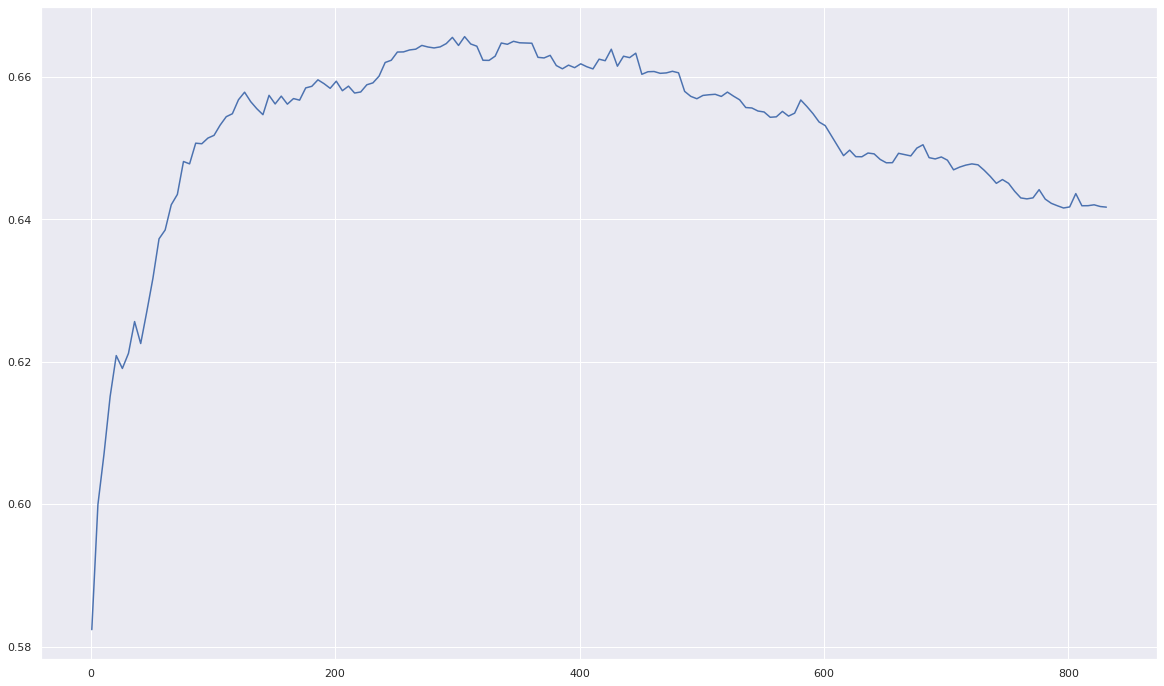

In [ ]:
sns.set(rc={'figure.figsize':(20,12)})
sns.lineplot(data=f1_results_unigram_bigram_supervised)

In [ ]:
# Getting the optimal number of features which will result in best mean cross validation F1-score from the dictionary

best_no_of_features= max(f1_results_unigram_bigram_supervised, key=f1_results_unigram_bigram_supervised.get)
best_no_of_features

306

In [ ]:
# Extracting the optimal number of features into a dataframe for training

chi2_columns = chi2_df_sorted.columns[:best_no_of_features]
scaled_train_supervised_unigram_bigram_df_chi_square = train_supervised_unigram_bigram_chi_square_df[chi2_columns]
scaled_test_supervised_unigram_bigram_df_chi_square = test_supervised_unigram_bigram_chi_square_df[chi2_columns]

In [ ]:
X_train = scaled_train_supervised_unigram_bigram_df_chi_square
X_test = scaled_test_supervised_unigram_bigram_df_chi_square

clf = LinearSVC(random_state=0).fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
print('Train Accuracy: ' + '{:.2%}'.format(accuracy_score(y_train, y_train_pred)))

y_test_pred = clf.predict(X_test)
print('Test Accuracy: ' + '{:.2%}'.format(accuracy_score(y_test, y_test_pred)))
print('Test F1 Score: ' + '{:.2%}'.format(f1_score(y_test, y_test_pred, average='weighted')))

## Cross Validation
cross_val_accuracy_scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=10, n_jobs=-1)   
print("Mean Cross Val Accuracy: " + '{:.2%}'.format(cross_val_accuracy_scores.mean()))
    
cross_val_f1_scores = cross_val_score(clf, X_train, y_train, scoring='f1_weighted', cv=10, n_jobs=-1)
print("Mean Cross Val F1 Score: " + '{:.2%}'.format(cross_val_f1_scores.mean()))

testing_matthew_coeff = matthews_corrcoef(y_test, y_test_pred)
print("Testing Matthew's coefficient:", round(testing_matthew_coeff,3))

Train Accuracy: 72.56%
Test Accuracy: 70.92%
Test F1 Score: 68.01%
Mean Cross Val Accuracy: 69.31%
Mean Cross Val F1 Score: 66.21%
Testing Matthew's coefficient: 0.397


With regularization

In [ ]:
X_train = scaled_train_supervised_unigram_bigram_df_chi_square
X_test = scaled_test_supervised_unigram_bigram_df_chi_square

clf = LinearSVC(random_state=0, C=1.2).fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
print('Train Accuracy: ' + '{:.2%}'.format(accuracy_score(y_train, y_train_pred)))

y_test_pred = clf.predict(X_test)
print('Test Accuracy: ' + '{:.2%}'.format(accuracy_score(y_test, y_test_pred)))
print('Test F1 Score: ' + '{:.2%}'.format(f1_score(y_test, y_test_pred, average='weighted')))

## Cross Validation
cross_val_accuracy_scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=10, n_jobs=-1)   
print("Mean Cross Val Accuracy: " + '{:.2%}'.format(cross_val_accuracy_scores.mean()))
    
cross_val_f1_scores = cross_val_score(clf, X_train, y_train, scoring='f1_weighted', cv=10, n_jobs=-1)
print("Mean Cross Val F1 Score: " + '{:.2%}'.format(cross_val_f1_scores.mean()))

testing_matthew_coeff = matthews_corrcoef(y_test, y_test_pred)
print("Testing Matthew's coefficient:", round(testing_matthew_coeff,3))

Train Accuracy: 72.56%
Test Accuracy: 70.92%
Test F1 Score: 68.05%
Mean Cross Val Accuracy: 69.16%
Mean Cross Val F1 Score: 66.14%
Testing Matthew's coefficient: 0.397
